In [1]:
import jdc
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env_test = gym.make("CartPole-v1")
env_test.observation_space, env_test.action_space.n

(Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32), 2)

In [3]:
class FCQ(torch.nn.Module):
    def __init__(self, input_shape, output_shape, hidden_layers,
                activation_fn=torch.nn.functional.relu,
                optimizer=torch.optim.RMSprop, learning_rate=0.0005) -> None:
        super().__init__()

        self.activation_fn = activation_fn

        self.input_layer = torch.nn.Linear(input_shape, hidden_layers[0])
        self.hidden_layers = torch.nn.ModuleList()
        for i in range(len(hidden_layers)-1):
            self.hidden_layers.append(torch.nn.Linear(hidden_layers[i], hidden_layers[i+1]))
        self.output_layer = torch.nn.Linear(hidden_layers[-1], output_shape)

        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        self.optimizer.zero_grad()

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
        return self.output_layer(x)

    def train(self, states, q_targets, actions):
        q_states = self(states)
        q_states_actions = torch.gather(q_states, 1, actions)
        td_errors = q_states_actions - q_targets
        loss = td_errors.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        loss.backward()

        self.optimizer.step()

    @staticmethod
    def reset_weights(m):
        for layer in m.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def reset(self):
        self.apply(FCQ.reset_weights)

In [4]:
class NFQ:
    def __init__(self, env, fcq, epsilon=0.1, gamma=1, batch_size=1024, epochs=40) -> None:
        self.fcq = fcq
        self.env = env
        self.batch_size = batch_size
        self.epochs = epochs
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_actions = env.action_space.n

In [5]:
%%add_to NFQ

def reset(self):
    self.fcq.reset()

In [6]:
%%add_to NFQ

def train(self, n_episodes):
    # 1. get a batch of experiences
    # loop 1->k:
    #   2. calculate target
    #   3. fit Q values using RMSprop & MSE
    # goto 1
    experiences = []
    step_count = 0
    rewards = np.zeros(n_episodes)
    avg_rewards = np.zeros(n_episodes)
    eval_rewards = np.zeros(n_episodes)
    for i in range(n_episodes):
        state = self.env.reset()
        while True:
            step_count += 1
            action = self.epsilon_greedy_policy(state)
            state_p, reward, done, info = self.env.step(action)
            rewards[i] += reward
            is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            experiences.append((state, action, reward, state_p, float(is_failure)))

            if len(experiences) >= self.batch_size:
                experiences = np.array(experiences, dtype=object)
                batches = [np.vstack(s) for s in experiences.T]
                self.optimize(batches)
                experiences = []

            if done:
                break

            state = state_p

        eval_rewards[i] = self.evaluate()
        avg_rewards[i] = rewards[max(0,i-100):i+1].mean()
        print("\rEpisode: {}, Steps: {}, Reward:{}".format(i, step_count, avg_rewards[i]), end="") # Not shown
    return rewards, avg_rewards, eval_rewards


In [7]:
%%add_to NFQ

def epsilon_greedy_policy(self, state):
    with torch.no_grad():
        q_values = self.fcq(state[np.newaxis]).detach().cpu().numpy().squeeze()
    if np.random.rand() < self.epsilon: 
        return np.random.randint(self.n_actions)
    else:
        return np.argmax(q_values)

def greedy_policy(self, state):
    q_values = self.fcq(state[np.newaxis]).detach().cpu().numpy().squeeze()
    return np.argmax(q_values)

In [8]:
%%add_to NFQ

def optimize(self, batches):
    states, actions, rewards, states_p, is_terminals = batches
    is_terminals = torch.from_numpy(is_terminals)
    rewards = torch.from_numpy(rewards)
    actions = torch.from_numpy(actions)
    for _ in range(self.epochs):
        q_states_p = self.fcq(states_p).detach()
        max_q_states_p = torch.max(q_states_p, axis=1, keepdims=True)[0]
        q_targets = rewards + self.gamma * max_q_states_p * (1 - is_terminals)

        self.fcq.train(states, q_targets, actions)

In [9]:
%%add_to NFQ

def iterate(self, n_runs, n_episodes):
    rewards = np.zeros((n_runs, n_episodes))
    avg_rewards = np.zeros((n_runs, n_episodes))
    eval_rewards = np.zeros((n_runs, n_episodes))
    for i in range(n_runs):
        print("\nRun " + str(i+1))
        self.reset()
        rew, avg_rew, eval_rew = self.train(n_episodes)
        rewards[i] = rew
        avg_rewards[i] = avg_rew 
        eval_rewards[i] = eval_rew
    return rewards, avg_rewards, eval_rewards

In [10]:
%%add_to NFQ

def evaluate(self):
    sum_rewards = 0
    state = self.env.reset()
    while True:
        action = self.greedy_policy(state)
        state_p, reward, done, _ = self.env.step(action)
        sum_rewards += reward

        if done:
            break

        state = state_p
    return sum_rewards

In [12]:
fcq = FCQ(4, 2, (512,128))
env = gym.make("CartPole-v1")
agent_nfq = NFQ(env, fcq, epsilon=0.5)

rewards_nfq, avg_nfq, eval_rewards = agent_nfq.iterate(5, 3000)


Run 1
Episode: 2999, Steps: 383183, Reward:191.5742574257426
Run 2
Episode: 2999, Steps: 289916, Reward:167.2970297029703
Run 3
Episode: 2999, Steps: 289750, Reward:164.92079207920793
Run 4
Episode: 2999, Steps: 142701, Reward:133.54455445544554
Run 5
Episode: 2999, Steps: 201515, Reward:180.31683168316832

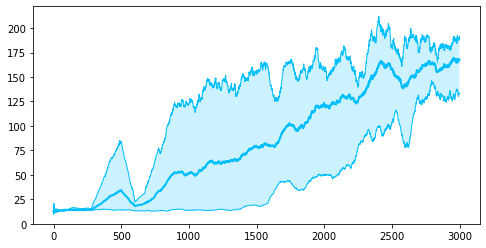

In [38]:
avg_nfq_min = np.min(avg_nfq, axis=0)
avg_nfq_max = np.max(avg_nfq, axis=0)
avg_nfq_mean = np.mean(avg_nfq, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_nfq_min, 'deepskyblue', linewidth=1)
plt.plot(avg_nfq_max, 'deepskyblue', linewidth=1)
plt.plot(avg_nfq_mean, 'deepskyblue', label='NFQ', linewidth=2)
plt.fill_between(np.arange(len(avg_nfq_mean)), avg_nfq_min, avg_nfq_max, facecolor='deepskyblue', alpha=0.2)
plt.show()

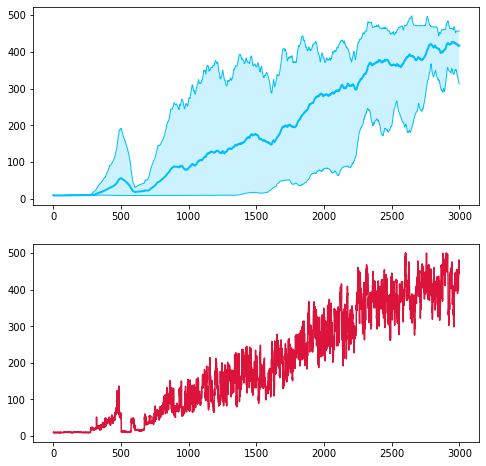

In [35]:
avg_eval = np.empty((5,3000))
for i in range(5):
    for j in range(3000):
        avg_eval[i,j] = eval_rewards[i,max(0,j-100):j+1].mean()

eval_rewards_min = np.min(avg_eval, axis=0)
eval_rewards_max = np.max(avg_eval, axis=0)
eval_rewards_mean = np.mean(avg_eval, axis=0)

plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.plot(eval_rewards_min, 'deepskyblue', linewidth=1)
plt.plot(eval_rewards_max, 'deepskyblue', linewidth=1)
plt.plot(eval_rewards_mean, 'deepskyblue', label='NFQ', linewidth=2)
plt.fill_between(np.arange(len(eval_rewards_mean)), eval_rewards_min, eval_rewards_max, facecolor='deepskyblue', alpha=0.2)

plt.subplot(2,1,2)
plt.plot(np.mean(eval_rewards, axis=0), color="crimson")
plt.show()